# 0. INITIALIZERS

In [1]:
### IMPORTS
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
### A HELPER FUNCTION TO DISPLAY SECTION TITLE
def print_section(title):
    print(f'{"="*60}\n{title}\n{"="*60}')

### SEE ALL COLUMNS
pd.set_option('display.max_columns', None)

# 1. DATA LOADING

In [3]:
### LOAD DATA
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 2. INITIAL DATA INSPECTION

## GET OVERVIEW

In [4]:
### TRAIN DATASET
print_section('TRAIN')
train.info()
display(train.head())
display(train.describe())

### TEST DATASET
print_section('TEST')
test.info()
display(test.head())
display(test.describe())

TRAIN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   p_id                   614 non-null    int64  
 1   no_times_pregnant      614 non-null    int64  
 2   glucose_concentration  614 non-null    int64  
 3   blood_pressure         614 non-null    int64  
 4   skin_fold_thickness    614 non-null    int64  
 5   serum_insulin          614 non-null    int64  
 6   bmi                    614 non-null    float64
 7   diabetes pedigree      614 non-null    float64
 8   age                    614 non-null    int64  
 9   diabetes               614 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 48.1 KB


,p_id,no_times_pregnant,glucose_concentration,blood_pressure,skin_fold_thickness,serum_insulin,bmi,diabetes pedigree,age,diabetes
0,316,2,112,68,22,94,34.1,0.315,26,0
1,25,11,143,94,33,146,36.6,0.254,51,1
2,710,2,93,64,32,160,38.0,0.674,23,1
3,658,1,120,80,48,200,38.9,1.162,41,0
4,542,3,128,72,25,190,32.4,0.549,27,1


,p_id,no_times_pregnant,glucose_concentration,blood_pressure,skin_fold_thickness,serum_insulin,bmi,diabetes pedigree,age,diabetes
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,385.773616,3.853420,120.542345,68.765472,20.244300,79.355049,31.909935,0.466342,33.325733,0.348534
std,223.603024,3.358126,31.252286,19.914836,15.886083,117.709950,8.007699,0.331090,11.929569,0.476895
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,191.250000,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.240250,24.000000,0.000000
50%,387.000000,3.000000,117.000000,72.000000,23.000000,17.000000,32.000000,0.361000,29.000000,0.000000
75%,572.750000,6.000000,139.000000,80.000000,32.000000,126.000000,36.600000,0.613500,41.000000,1.000000
max,768.000000,17.000000,197.000000,114.000000,63.000000,846.000000,59.400000,2.420000,81.000000,1.000000


TEST
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   p_id                   154 non-null    int64  
 1   no_times_pregnant      154 non-null    int64  
 2   glucose_concentration  154 non-null    int64  
 3   blood_pressure         154 non-null    int64  
 4   skin_fold_thickness    154 non-null    int64  
 5   serum_insulin          154 non-null    int64  
 6   bmi                    154 non-null    float64
 7   diabetes pedigree      154 non-null    float64
 8   age                    154 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 11.0 KB


,p_id,no_times_pregnant,glucose_concentration,blood_pressure,skin_fold_thickness,serum_insulin,bmi,diabetes pedigree,age
0,437,12,140,85,33,0,37.4,0.244,41
1,411,6,102,90,39,0,35.7,0.674,28
2,639,7,97,76,32,91,40.9,0.871,32
3,213,7,179,95,31,0,34.2,0.164,60
4,181,6,87,80,0,0,23.2,0.084,32


,p_id,no_times_pregnant,glucose_concentration,blood_pressure,skin_fold_thickness,serum_insulin,bmi,diabetes pedigree,age
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,379.422078,3.811688,122.298701,70.461039,21.701299,81.571429,32.322078,0.493942,32.902597
std,215.338912,3.425719,34.769480,16.935917,16.213095,105.178271,7.386724,0.332439,11.090106
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084000,21.000000
25%,194.250000,1.000000,97.000000,64.000000,0.000000,0.000000,28.150000,0.248000,24.000000
50%,383.000000,3.000000,115.000000,72.000000,24.500000,52.000000,32.900000,0.411500,29.500000
75%,583.250000,6.000000,144.750000,78.000000,33.000000,129.500000,36.200000,0.654750,40.000000
max,738.000000,14.000000,199.000000,122.000000,99.000000,474.000000,67.100000,2.137000,66.000000


**REMARKS**:
- 5 non-zero numeric features (`glucose_concentration`, `blood_pressure`, `skin_fold_thickness`, `serum_insulin`, `bmi`) have invalid zeros.
- No column has any missing values.

## IDENTIFY ISSUES FOR DATA CLEANING
A systematic check on potential data issues.

### A. CHECK DATA TYPES
- Are all the columns in both datasets numeric (`int64` or `float64`)?
- Only numeric columns are used in building ML models. 

In [5]:
print_section('CHECK DATA TYPES')

def check_data_types(df, name):
    if df.columns.equals(df.select_dtypes(include=['float64', 'int64']).columns):
        print(f'✅ {name}: All data types are numeric (float64 or int64).')
    else: 
        print(f'❌ {name}: There are non-numeric data types.')

check_data_types(train, 'train')
check_data_types(test, 'test')

CHECK DATA TYPES
✅ train: All data types are numeric (float64 or int64).
✅ test: All data types are numeric (float64 or int64).


### B. CHECK DUPLICATES
- Are there any duplicated rows?
- Are there any duplicated id?

In [6]:
print_section('CHECK ROW DUPLICATES')

def check_row_dup(df, name):
    row_dup = df.duplicated().sum()
    if row_dup == 0:
        print(f'✅ {name}: {row_dup} row duplicate found.')
    else: 
        print(f'❌ {name}: {row_dup} row duplicates found.')

check_row_dup(train, 'train')
check_row_dup(test, 'test')

CHECK ROW DUPLICATES
✅ train: 0 row duplicate found.
✅ test: 0 row duplicate found.


In [7]:
print_section('CHECK ID DUPLICATES')

def check_id_dup(df, name):
    total_entries = len(df)
    unique_id = df['p_id'].nunique()
    print(f"Total entries: {total_entries}")
    print(f"Unique p_id: {unique_id}")
    if total_entries == unique_id:
        print(f'✅ {name}: No id duplicate found. 1 unique p_id per patient.\n')
    else: 
        print(f'❌ {name}: Multiple entries per patient detected!\n')

check_id_dup(train, 'train')
check_id_dup(test, 'test')

CHECK ID DUPLICATES
Total entries: 614
Unique p_id: 614
✅ train: No id duplicate found. 1 unique p_id per patient.

Total entries: 154
Unique p_id: 154
✅ test: No id duplicate found. 1 unique p_id per patient.



### C. CHECK MISSING VALUES
- Are there any columns with missing values?
- If yes, how much do the missing values account for?

In [8]:
print_section('CHECK MISSING VALUES')

def check_missing(df, name):
    ### COUNT OF MISSING VALUES
    miss_cnt = df.isnull().sum()
    
    ### PERCENTAGE OF MISSING VALUES ROUNDED TO 2 DP
    miss_pct = (miss_cnt / len(df) * 100).round(2)
    
    ### DF CONTAINING COLUMNS WITH MISSING VALUES
    miss_df = pd.DataFrame({'missing_count': miss_cnt[miss_cnt>0],
                               'missing_percentage': miss_pct[miss_pct>0]}) \
                    .sort_values('missing_count', ascending=False)

    if len(miss_df) > 0:
        print('\nColumns with missing values:')
        print(miss_df)
        print(f"\n❌ {name}: Missing values detected.")
        print('Remove columns with % missing more than threshold in 3. DATA CLEANING.')
    else:
        print(miss_cnt)
        print(f"✅ {name}: No missing values detected.\n")

check_missing(train, 'train')
check_missing(test, 'test')

CHECK MISSING VALUES
p_id                     0
no_times_pregnant        0
glucose_concentration    0
blood_pressure           0
skin_fold_thickness      0
serum_insulin            0
bmi                      0
diabetes pedigree        0
age                      0
diabetes                 0
dtype: int64
✅ train: No missing values detected.

p_id                     0
no_times_pregnant        0
glucose_concentration    0
blood_pressure           0
skin_fold_thickness      0
serum_insulin            0
bmi                      0
diabetes pedigree        0
age                      0
dtype: int64
✅ test: No missing values detected.



### D. CHECK INVALID VALUES
- Are there any columns with invalid values, i.e. values that are unexpected based on domain understanding?
- From the overview earlier, 5 numerical non-zero columns have invalid zeros.

In [9]:
### 1. DEFINE COLUMNS THAT CAN BE ZERO BUT NOT NEGATIVE
test_zero_cols = ['no_times_pregnant', 'diabetes pedigree']
train_zero_cols = test_zero_cols + ['diabetes']

### 2. DEFINE COLUMNS THAT MUST BE POSITIVE (NOT ZERO/NEGATIVE)
pos_cols = [col for col in train.columns if col not in train_zero_cols]

### 3. UDF TO IDENTIFY INVALID (ZERO/NEGATIVE) VALUES
def check_invalid(df, zero_cols, pos_cols, name):
    print_section(f"CHECK INVALID VALUES - {name}")
    
    ### COLUMNS THAT CAN BE ZERO BUT NOT NEGATIVE
    neg_only_cnt = (df[zero_cols] < 0).sum()
    neg_only_pct = (neg_only_cnt / len(df) * 100).round(1)
    zero_df = pd.DataFrame({
        "negatives_count": neg_only_cnt,
        "negatives_percent": neg_only_pct
    })
    print("1. COLUMNS THAT CAN BE ZERO BUT NOT NEGATIVE (CHECK NEGATIVE)")
    display(zero_df)
    
    ### COLUMNS THAT MUST BE POSITIVE (NOT ZERO/NEGATIVE)
    zero_cnt = (df[pos_cols] == 0).sum()
    zero_pct = (zero_cnt / len(df) * 100).round(1)
    neg_cnt = (df[pos_cols] < 0).sum()
    neg_pct = (neg_cnt / len(df) * 100).round(1)
    pos_df = pd.DataFrame({
        "zeros_count": zero_cnt,
        "zeros_percent": zero_pct,
        "negatives_count": neg_cnt,
        "negatives_percent": neg_pct
    })
    print("2. COLUMNS THAT MUST BE POSITIVE (CHECK ZERO/NEGATIVE)")
    display(pos_df)

    return zero_df, pos_df

### 4. OUTPUT
train_zero, train_pos = check_invalid(train, train_zero_cols, pos_cols, 'TRAIN')
test_zero, test_pos = check_invalid(test, test_zero_cols, pos_cols, 'TEST')

CHECK INVALID VALUES - TRAIN
1. COLUMNS THAT CAN BE ZERO BUT NOT NEGATIVE (CHECK NEGATIVE)


,negatives_count,negatives_percent
no_times_pregnant,0,0.0
diabetes pedigree,0,0.0
diabetes,0,0.0


2. COLUMNS THAT MUST BE POSITIVE (CHECK ZERO/NEGATIVE)


,zeros_count,zeros_percent,negatives_count,negatives_percent
p_id,0,0.0,0,0.0
glucose_concentration,4,0.7,0,0.0
blood_pressure,31,5.0,0,0.0
skin_fold_thickness,187,30.5,0,0.0
serum_insulin,304,49.5,0,0.0
bmi,10,1.6,0,0.0
age,0,0.0,0,0.0


CHECK INVALID VALUES - TEST
1. COLUMNS THAT CAN BE ZERO BUT NOT NEGATIVE (CHECK NEGATIVE)


,negatives_count,negatives_percent
no_times_pregnant,0,0.0
diabetes pedigree,0,0.0


2. COLUMNS THAT MUST BE POSITIVE (CHECK ZERO/NEGATIVE)


,zeros_count,zeros_percent,negatives_count,negatives_percent
p_id,0,0.0,0,0.0
glucose_concentration,1,0.6,0,0.0
blood_pressure,4,2.6,0,0.0
skin_fold_thickness,40,26.0,0,0.0
serum_insulin,70,45.5,0,0.0
bmi,1,0.6,0,0.0
age,0,0.0,0,0.0


**REMARKS**
- ❌ Both train and test datasets have 5 non-zero columns with invalid zero values.
- We shall treat the invalid values as "missing values".
- In `3. DATA CLEANING`, the columns with "missing values (invalid values)" above a percentage threshold will be dropped, whereas the others below the threshold will be imputed using median.
- Invalid value threshold: 30%
- Columns to impute: `glucose_concentration`, `blood_pressure`, `bmi`
- Columns to drop: `skin_fold_thickness`, `serum_insulin`
- `skin_fold_thickness` is decided to be dropped.
    - It has significant invalid percent (26% and 30.5%).
    - It is a proxy for body fat, which is sufficiently represented by `bmi`.
    - Imputing will likely introduce bias for marginal gain in model performance. 

### E. CHECK OUTLIERS
- Methods: IQR & box plot.
- TRAIN dataset is used for the bounds for both TRAIN dataset & TEST dataset.

In [10]:
### DEFINE FEATURES (EXCLUDE ID & TARGET)
feature_cols = [c for c in train.columns if c not in ['p_id', 'diabetes']]
print(f"Feature columns for outlier detection: {feature_cols}")
print(f"\nTotal: {len(feature_cols)}")

### UDF TO COMPUTE IQR BOUNDARIES
# For each column in col, compute IQR-based lower and upper bounds.
# Returns (lower, upper) where lower = Q1 - 1.5*IQR and upper = Q3 + 1.5*IQR.
def compute_iqr_bounds(df, col):
    s = df[col]
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

### UDF TO COUNT OUTLIERS BEFORE CAPPING
def outlier_counts_by_bounds(df, cols, bounds_source='train'):
    counts = {}
    ### FOR EACH COLUMN IN COLS
    for col in cols:
        s = df[col]
        ### COMPUTE IQR BOUNDS
        lower, upper = compute_iqr_bounds(df, col)
        ### COUNT OUTLIERS OUTSIDE THOSE BOUNDS
        counts[col] = int(((s < lower) | (s > upper)).sum())
    return pd.Series(counts)

Feature columns for outlier detection: ['no_times_pregnant', 'glucose_concentration', 'blood_pressure', 'skin_fold_thickness', 'serum_insulin', 'bmi', 'diabetes pedigree', 'age']

Total: 8


CHECK OUTLIERS (OUTSIDE IQR BOUNDS OF TRAIN)


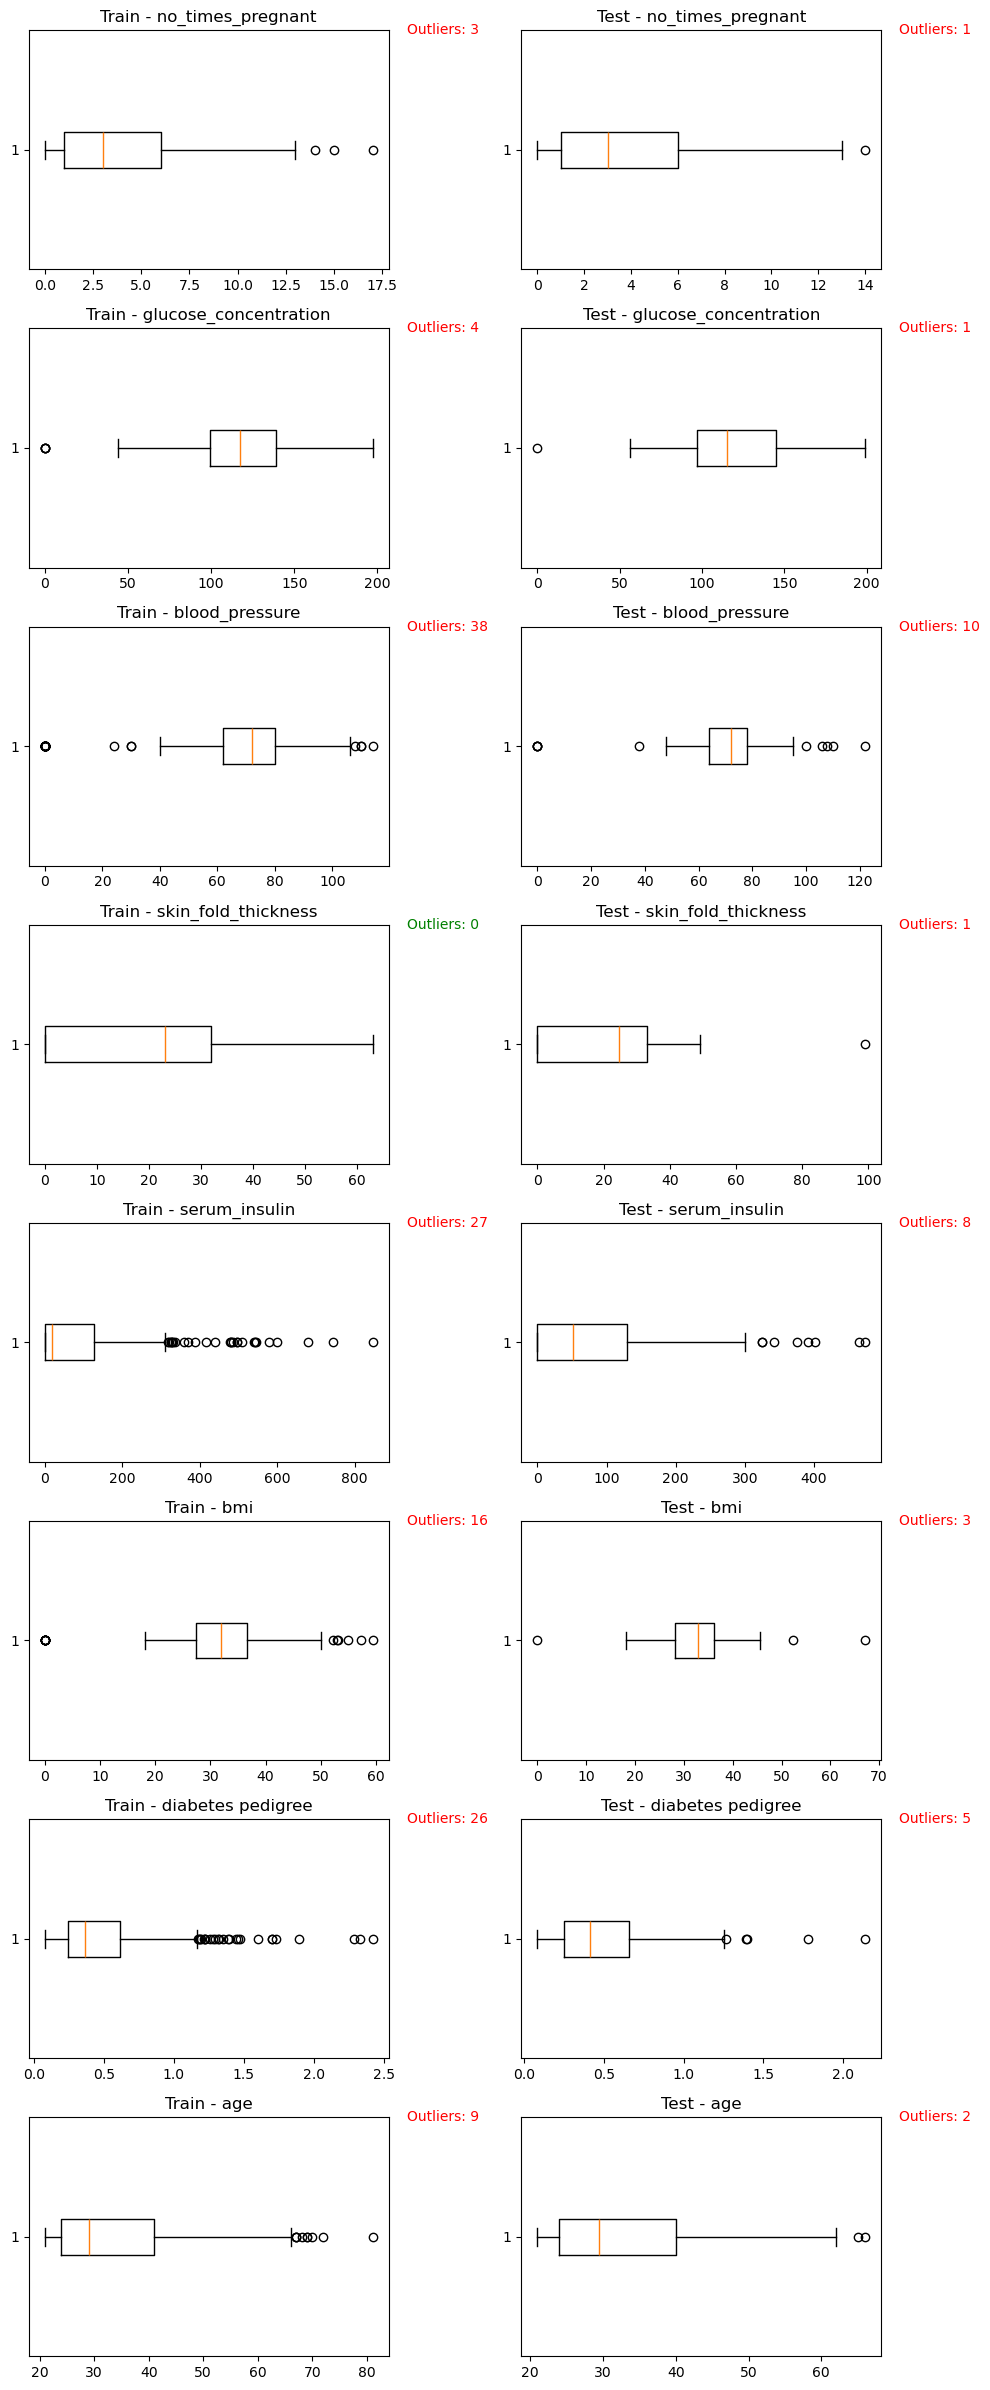

In [11]:
### PREP THE SUBPLOT GRID
n_featureCols = len(feature_cols)
ncols = 2  # TRAIN | TEST
nrows = n_featureCols  # ONE ROW PER FEATURE
fig, axes = plt.subplots(nrows, ncols, figsize=(10, nrows*3))

print_section('CHECK OUTLIERS (OUTSIDE IQR BOUNDS OF TRAIN)')

### GET OUTLIER COUNTS
before_train_counts = outlier_counts_by_bounds(train, feature_cols)
before_test_counts = outlier_counts_by_bounds(test, feature_cols)

### FOR EACH COLUMN IN TRAIN/TEST, PLOT THE BOXPLOT & SHOW OUTLIER COUNT
for i, c in enumerate(feature_cols):
    ### TRAIN BOXPLOT (LEFT COLUMN)
    axes[i, 0].boxplot(train[c], vert=False)
    axes[i, 0].set_title(f'Train - {c}')
    ### RED IF OUTLIERS; GREEN IF NO OUTLIERS
    train_color = 'green' if before_train_counts[c] == 0 else 'red'
    axes[i, 0].text(1.05, 1, f"Outliers: {before_train_counts[c]}", 
                    transform=axes[i, 0].transAxes, fontsize=10, color=train_color, va='center')

    axes[i, 1].boxplot(test[c], vert=False)
    axes[i, 1].set_title(f'Test - {c}')
    ### RED IF OUTLIERS; GREEN IF NO OUTLIERS
    test_color = 'green' if before_test_counts[c] == 0 else 'red'
    axes[i, 1].text(1.05, 1, f"Outliers: {before_test_counts[c]}", 
                    transform=axes[i, 1].transAxes, fontsize=10, color=test_color, va='center')

plt.tight_layout()
plt.show()

**REMARKS**
- ❌ Both datasets have outliers, except `skin_fold_thickness` in train.
- We shall ignore the outlier plots in `skin_fold_thickness` and `insulin_serum` which will be dropped later in `3. DATA CLEANING`.
- For other outliers, they will be **intentionally left unmodified** during `3. DATA CLEANING` as they represent legitimate, extreme patient medical characteristics, rather than systematic data errors, due to the small percentage they account for. 

# 3. DATA CLEANING
- From `2. INITIAL DATA INSPECTION`, there are no invalid data types, duplicates, or missing values.
- Columns with invalid values will be imputed or dropped.
- Outliers will be left unmodified.

## D. HANDLE INVALID VALUES
From `2. INITIAL DATA INSPECTION`,
- Invalid value threshold: 30%
- Columns to impute: `glucose_concentration`, `blood_pressure`, `bmi`
- Columns to drop: `skin_fold_thickness`, `serum_insulin`
- `skin_fold_thickness` is decided to be dropped.
    - It has significant invalid percent (26% and 30.5%).
    - It is a proxy for body fat, which is sufficiently represented by `bmi`.
    - Imputing will likely introduce bias for marginal gain in model performance. 

In [12]:
print_section('HANDLE INVALID VALUES')

### DEFINE COLUMNS TO DROP/IMPUTE
cols_drop = ['skin_fold_thickness', 'serum_insulin']
cols_imp = ['glucose_concentration', 'blood_pressure', 'bmi']

### DROP COLUMNS & CREATE COPIES FOR IMPUTATION
print(f"Dropping columns {cols_drop}...\n")
train_imp = train.drop(cols_drop, axis=1).copy()
test_imp = test.drop(cols_drop, axis=1).copy()

### SANITY CHECK
print(f"Train: {train.shape} -> {train_imp.shape}")
print(f"Test: {test.shape} -> {test_imp.shape}")

### IMPUTE ZEROS WITH TRAIN'S MEDIAN VALUES
print(f"\nImputing zeros in {cols_imp}...\n")
for col in cols_imp:
    ### IMPUTE
    median_val = train_imp[col].median()
    train_imp[col] = train_imp[col].replace(0, median_val) 
    test_imp[col] = test_imp[col].replace(0, median_val)

    ### SANITY CHECK
    zeros_train = (train_imp[col] == 0).sum()
    zeros_test = (test_imp[col] == 0).sum()
    print(f"{col}: train zeros = {zeros_train}, test zeros = {zeros_test}")

### LAST CHECK
print("\nColumn Stats")
display(train_imp.describe())
display(test_imp.describe())

HANDLE INVALID VALUES
Dropping columns ['skin_fold_thickness', 'serum_insulin']...

Train: (614, 10) -> (614, 8)
Test: (154, 9) -> (154, 7)

Imputing zeros in ['glucose_concentration', 'blood_pressure', 'bmi']...

glucose_concentration: train zeros = 0, test zeros = 0
blood_pressure: train zeros = 0, test zeros = 0
bmi: train zeros = 0, test zeros = 0

Column Stats


,p_id,no_times_pregnant,glucose_concentration,blood_pressure,bmi,diabetes pedigree,age,diabetes
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,385.773616,3.853420,121.304560,72.400651,32.431107,0.466342,33.325733,0.348534
std,223.603024,3.358126,29.688213,12.031595,6.873171,0.331090,11.929569,0.476895
min,1.000000,0.000000,44.000000,24.000000,18.200000,0.078000,21.000000,0.000000
25%,191.250000,1.000000,100.000000,64.000000,27.500000,0.240250,24.000000,0.000000
50%,387.000000,3.000000,117.000000,72.000000,32.000000,0.361000,29.000000,0.000000
75%,572.750000,6.000000,139.000000,80.000000,36.600000,0.613500,41.000000,1.000000
max,768.000000,17.000000,197.000000,114.000000,59.400000,2.420000,81.000000,1.000000


,p_id,no_times_pregnant,glucose_concentration,blood_pressure,bmi,diabetes pedigree,age
count,154.000000,154.000000,154.000000,154.000000,154.00000,154.000000,154.000000
mean,379.422078,3.811688,123.058442,72.331169,32.52987,0.493942,32.902597
std,215.338912,3.425719,33.328085,12.392310,6.90599,0.332439,11.090106
min,4.000000,0.000000,56.000000,38.000000,18.20000,0.084000,21.000000
25%,194.250000,1.000000,97.500000,66.000000,28.37500,0.248000,24.000000
50%,383.000000,3.000000,115.500000,72.000000,32.90000,0.411500,29.500000
75%,583.250000,6.000000,144.750000,78.000000,36.20000,0.654750,40.000000
max,738.000000,14.000000,199.000000,122.000000,67.10000,2.137000,66.000000


## LATEST CLEANED DATA

In [13]:
train_clean = train_imp.copy()
test_clean = test_imp.copy()
feature_cols_clean = [c for c in train_clean.columns if c not in ['p_id', 'diabetes']]
print(f"Feature Columns After Cleaning: {feature_cols_clean}\n")

print_section('TRAIN_CLEAN')
train_clean.info()
display(train_clean.head())
print_section('TEST_CLEAN')
test_clean.info()
display(test_clean.head())

print('''
✅ DATA CLEANING COMPLETED!
- TRAIN DATASET IS READY FOR EDA.
- TEST DATASET IS READY FOR FEATURE ENGINEERING.
''')

Feature Columns After Cleaning: ['no_times_pregnant', 'glucose_concentration', 'blood_pressure', 'bmi', 'diabetes pedigree', 'age']

TRAIN_CLEAN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   p_id                   614 non-null    int64  
 1   no_times_pregnant      614 non-null    int64  
 2   glucose_concentration  614 non-null    int64  
 3   blood_pressure         614 non-null    int64  
 4   bmi                    614 non-null    float64
 5   diabetes pedigree      614 non-null    float64
 6   age                    614 non-null    int64  
 7   diabetes               614 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 38.5 KB


,p_id,no_times_pregnant,glucose_concentration,blood_pressure,bmi,diabetes pedigree,age,diabetes
0,316,2,112,68,34.1,0.315,26,0
1,25,11,143,94,36.6,0.254,51,1
2,710,2,93,64,38.0,0.674,23,1
3,658,1,120,80,38.9,1.162,41,0
4,542,3,128,72,32.4,0.549,27,1


TEST_CLEAN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   p_id                   154 non-null    int64  
 1   no_times_pregnant      154 non-null    int64  
 2   glucose_concentration  154 non-null    int64  
 3   blood_pressure         154 non-null    int64  
 4   bmi                    154 non-null    float64
 5   diabetes pedigree      154 non-null    float64
 6   age                    154 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 8.6 KB


,p_id,no_times_pregnant,glucose_concentration,blood_pressure,bmi,diabetes pedigree,age
0,437,12,140,85,37.4,0.244,41
1,411,6,102,90,35.7,0.674,28
2,639,7,97,76,40.9,0.871,32
3,213,7,179,95,34.2,0.164,60
4,181,6,87,80,23.2,0.084,32



✅ DATA CLEANING COMPLETED!
- TRAIN DATASET IS READY FOR EDA.
- TEST DATASET IS READY FOR FEATURE ENGINEERING.



# 4. EDA
- EDA is done only on the TRAIN dataset without touching the TEST dataset.
- This is to prevent leaking information and artificially improving ML model performance.

In [14]:
### SET PLOTTING STYLE
sns.set_theme(style='whitegrid', rc={'figure.figsize': (12, 6)})

## TARGET VARIABLE ANALYSIS

TARGET VARIABLE ANALYSIS

Diabetes Distribution:
Non-Diabetic (0): 400 (65.1%)
Diabetic (1): 214 (34.9%)

Non-Diabetic-to-Diabetic Ratio: 1.87:1


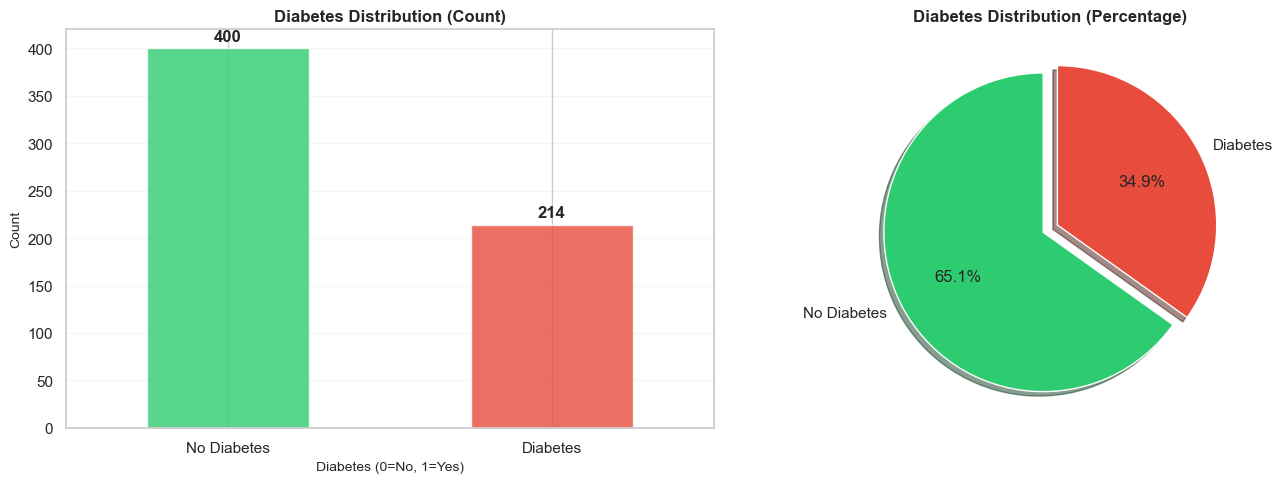

In [15]:
print_section('TARGET VARIABLE ANALYSIS')

### SHOW COUNT AND PERCENTAGE
diabetes_count = train_clean['diabetes'].value_counts()
diabetes_pct = train_clean['diabetes'].value_counts(normalize=True) * 100

# :.1f and :.2f to round to 1 and 2 decimal place(s) respectively
print('\nDiabetes Distribution:')
print(f'Non-Diabetic (0): {diabetes_count[0]} ({diabetes_pct[0]:.1f}%)')
print(f'Diabetic (1): {diabetes_count[1]} ({diabetes_pct[1]:.1f}%)')
print(f'\nNon-Diabetic-to-Diabetic Ratio: {diabetes_count[0]/diabetes_count[1]:.2f}:1')

### VISUALIZE TARGET DISTRIBUTION
# Bar Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['#2ecc71', '#e74c3c']
diabetes_count.plot(kind='bar', ax=axes[0], color=colors, alpha=0.8)
axes[0].set_title('Diabetes Distribution (Count)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Diabetes (0=No, 1=Yes)', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].set_xticklabels(['No Diabetes', 'Diabetes'], rotation=0)
axes[0].grid(axis='y', alpha=0.2)

# Add count labels on bars
for i, v in enumerate(diabetes_count):
    axes[0].text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

# Pie Chart
axes[1].pie(diabetes_count, labels=['No Diabetes', 'Diabetes'], 
            colors=colors, autopct='%1.1f%%', startangle=90,
            explode=(0.05, 0.05), shadow=True)
axes[1].set_title('Diabetes Distribution (Percentage)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

- Dataset has class imbalance - more non-diabetic patients.
- This needs to be considered during model training and evaluation.

## STATISTICAL SUMMARY BY DIABETES STATUS

In [16]:
print_section('STATISTICAL SUMMARY BY DIABETES')

### SUMMARY STATISTICS GROUPED BY DIABETES STATUS
print('\n--- Non-Diabetic (diabetes=0) ---')
non_diabetic_stat = train_clean[train_clean['diabetes']==0][feature_cols_clean].describe()
display(non_diabetic_stat.round(2))

print('\n--- Diabetic (diabetes=1) ---')
diabetic_stat = train_clean[train_clean['diabetes']==1][feature_cols_clean].describe()
display(diabetic_stat.round(2))

### COMPARE MEANS BETWEEN GROUPS
print('\n--- Mean Comparison: Diabetic vs Non-Diabetic ---')
mean_compare = pd.DataFrame({
    'Non-Diabetic': train_clean[train_clean['diabetes']==0][feature_cols_clean].mean(),
    'Diabetic': train_clean[train_clean['diabetes']==1][feature_cols_clean].mean(),
})
mean_compare['Difference'] = mean_compare['Diabetic'] - mean_compare['Non-Diabetic']
mean_compare['Pct_Change'] = (mean_compare['Difference'] / mean_compare['Non-Diabetic'] * 100)
display(mean_compare.round(2))

STATISTICAL SUMMARY BY DIABETES

--- Non-Diabetic (diabetes=0) ---


,no_times_pregnant,glucose_concentration,blood_pressure,bmi,diabetes pedigree,age
count,400.00,400.00,400.00,400.00,400.00,400.00
mean,3.34,110.41,70.78,30.94,0.42,31.39
std,3.01,23.78,11.61,6.58,0.30,12.00
min,0.00,44.00,24.00,18.20,0.08,21.00
25%,1.00,94.00,62.00,25.90,0.23,23.00
50%,2.00,108.00,72.00,30.10,0.33,27.00
75%,5.00,124.25,78.00,35.30,0.55,37.00
max,13.00,197.00,110.00,57.30,2.33,81.00



--- Diabetic (diabetes=1) ---


,no_times_pregnant,glucose_concentration,blood_pressure,bmi,diabetes pedigree,age
count,214.00,214.00,214.00,214.00,214.00,214.00
mean,4.81,141.67,75.43,35.22,0.54,36.94
std,3.74,28.93,12.25,6.54,0.37,10.95
min,0.00,78.00,30.00,22.90,0.12,21.00
25%,1.25,119.00,68.00,30.50,0.26,28.00
50%,4.00,140.00,74.00,34.05,0.43,36.00
75%,8.00,164.75,84.00,38.92,0.73,44.75
max,17.00,197.00,114.00,59.40,2.42,70.00



--- Mean Comparison: Diabetic vs Non-Diabetic ---


,Non-Diabetic,Diabetic,Difference,Pct_Change
no_times_pregnant,3.34,4.81,1.47,44.10
glucose_concentration,110.41,141.67,31.27,28.32
blood_pressure,70.78,75.43,4.66,6.58
bmi,30.94,35.22,4.28,13.84
diabetes pedigree,0.42,0.54,0.12,28.35
age,31.39,36.94,5.55,17.67


- Diabetic patients have significantly higher values in all numerical features as shown above.

## FEATURE DISTRIBUTIONS BY DIABETES

FEATURE DISTRIBUTIONS BY DIABETES


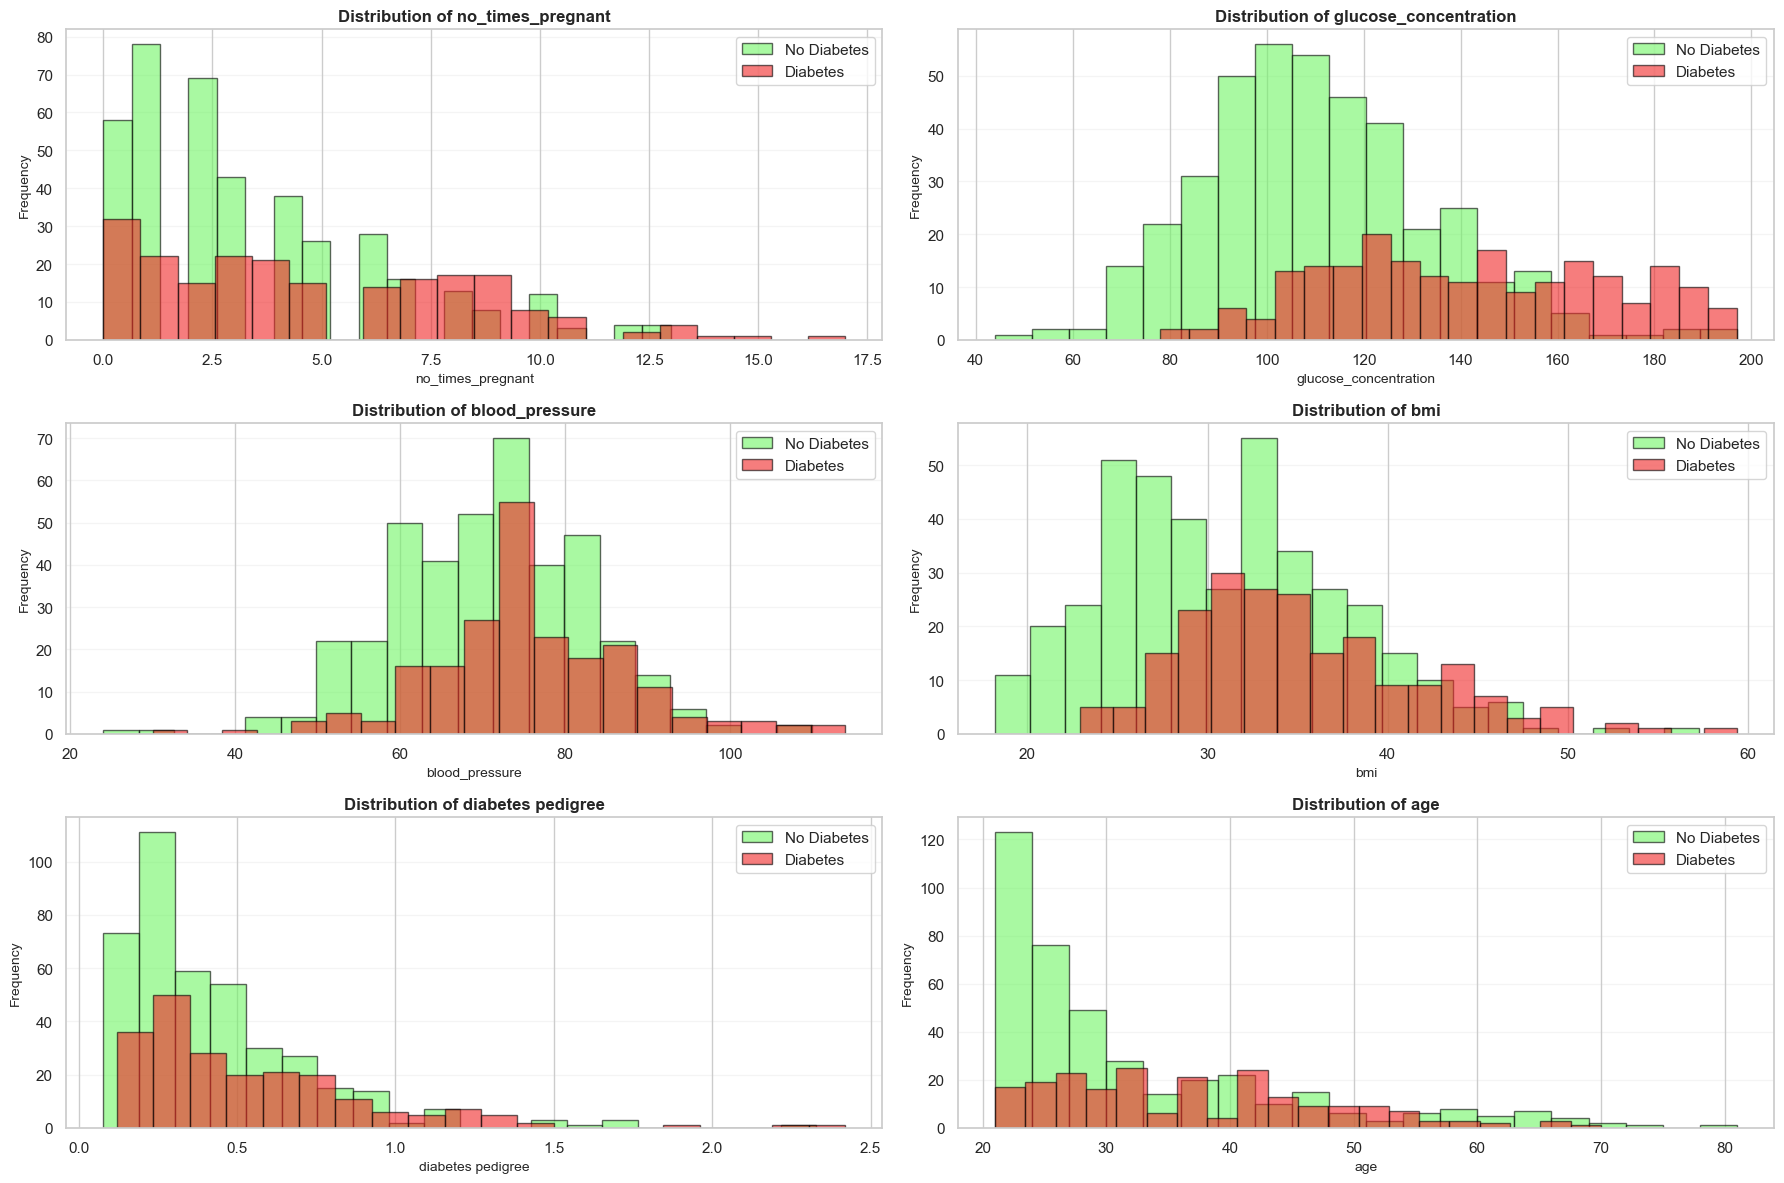

In [17]:
print_section('FEATURE DISTRIBUTIONS BY DIABETES')

### SET THE SUBPLOT GRID SHAPE
n_cols = 2
# Count no. of rows of subplots based on feature cols
n_rows = int(np.ceil(len(feature_cols_clean) / n_cols))
# Create the grid 18-inch wide with 4 inches per row
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*4))
# Flatten the 2D array of axes (n_rows, n_cols) to 1D for easy indexing of each subplot as axes(idx)
axes = axes.ravel() 

### FOR EVERY COLUMN AND ITS ENUMERATED INDEX IN feature_cols_clean
for idx, col in enumerate(feature_cols_clean):
    ### PLOT FOR NON-DIABETIC
    train_clean[train_clean['diabetes']==0][col].hist(
        bins=20, alpha=0.6, label='No Diabetes', 
        color='#70F564', ax=axes[idx], edgecolor='black'
    )
    ### PLOT FOR DIABETIC
    train_clean[train_clean['diabetes']==1][col].hist(
        bins=20, alpha=0.6, label='Diabetes', 
        color='#F02626', ax=axes[idx], edgecolor='black'
    )
    ### SET PLOT ANNOTATIONS
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.2)

### HIDE UNUSED SUBPLOT (IF ANY)
for idx in range(len(feature_cols_clean), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

- Obvious difference in glucose_concentration and BMI between diabetic and non-diabetic.
- Other features have similar distributions, though not perfectly equal.

## CORRELATION ANALYSIS

CORRELATION ANALYSIS


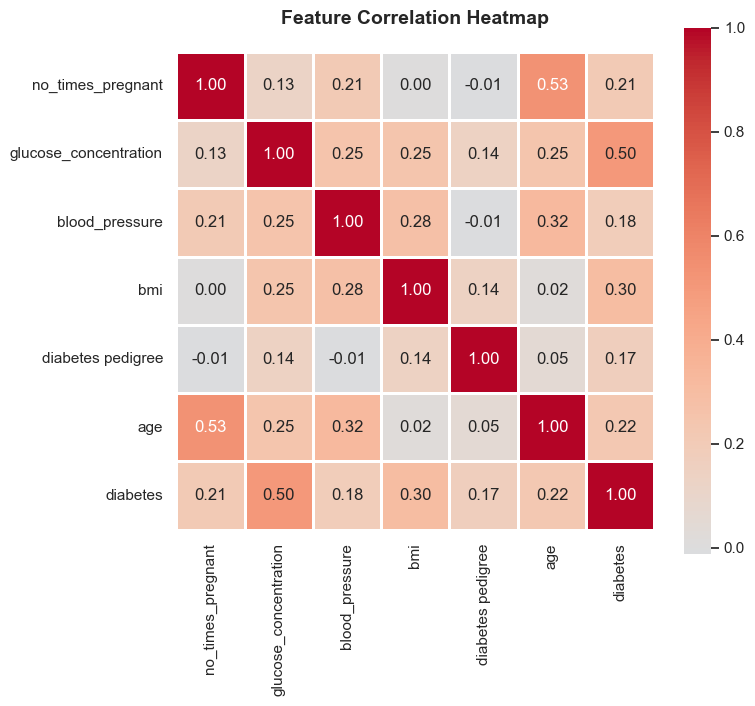


--- Correlations with Diabetes (Target Variable) ---
diabetes                 1.000
glucose_concentration    0.502
bmi                      0.297
age                      0.222
no_times_pregnant        0.209
blood_pressure           0.185
diabetes pedigree        0.173
Name: diabetes, dtype: float64


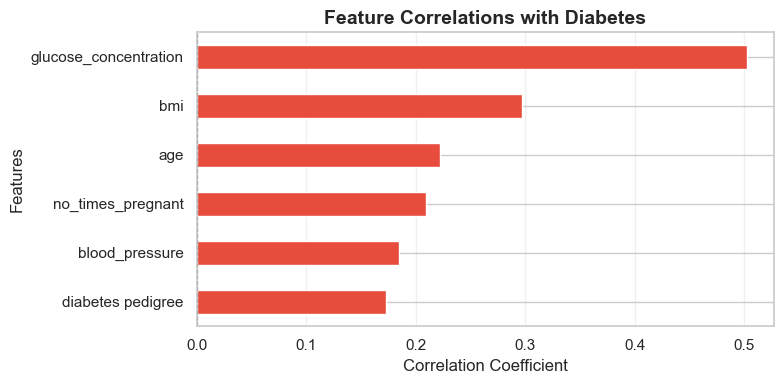

In [18]:
print_section('CORRELATION ANALYSIS')

### CALCULATE CORRELATION MATRIX
corr_matrix = train_clean[feature_cols_clean + ['diabetes']].corr()

### PLOT CORRELATION HEATMAP
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### SHOW CORRELATIONS WITH TARGET
print('\n--- Correlations with Diabetes (Target Variable) ---')
diabetes_corr = corr_matrix['diabetes'].sort_values(ascending=False).round(3)
print(diabetes_corr)

### VISUALIZE CORRELATIONS WITH TARGET
plt.figure(figsize=(8, 4))

# Remove self-correlation (target-target)
# Show the highest corr value at the top 
diabetes_corr_plot = diabetes_corr.drop('diabetes').sort_values() 
               
colorsCorr = ['#e74c3c' if x > 0 else '#3498db' for x in diabetes_corr_plot.values]
diabetes_corr_plot.plot(kind='barh', color=colorsCorr)
plt.title('Feature Correlations with Diabetes', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

- Glucose concentration has STRONGEST correlation with diabetes (0.502)
- BMI is second most correlated with diabetes (0.299)
- Other features show moderate-to-low correlation
- Some features are correlated with each other (multicollinearity)

## BOX PLOTS BY DIABETES

BOX PLOTS BY DIABETES STATUS


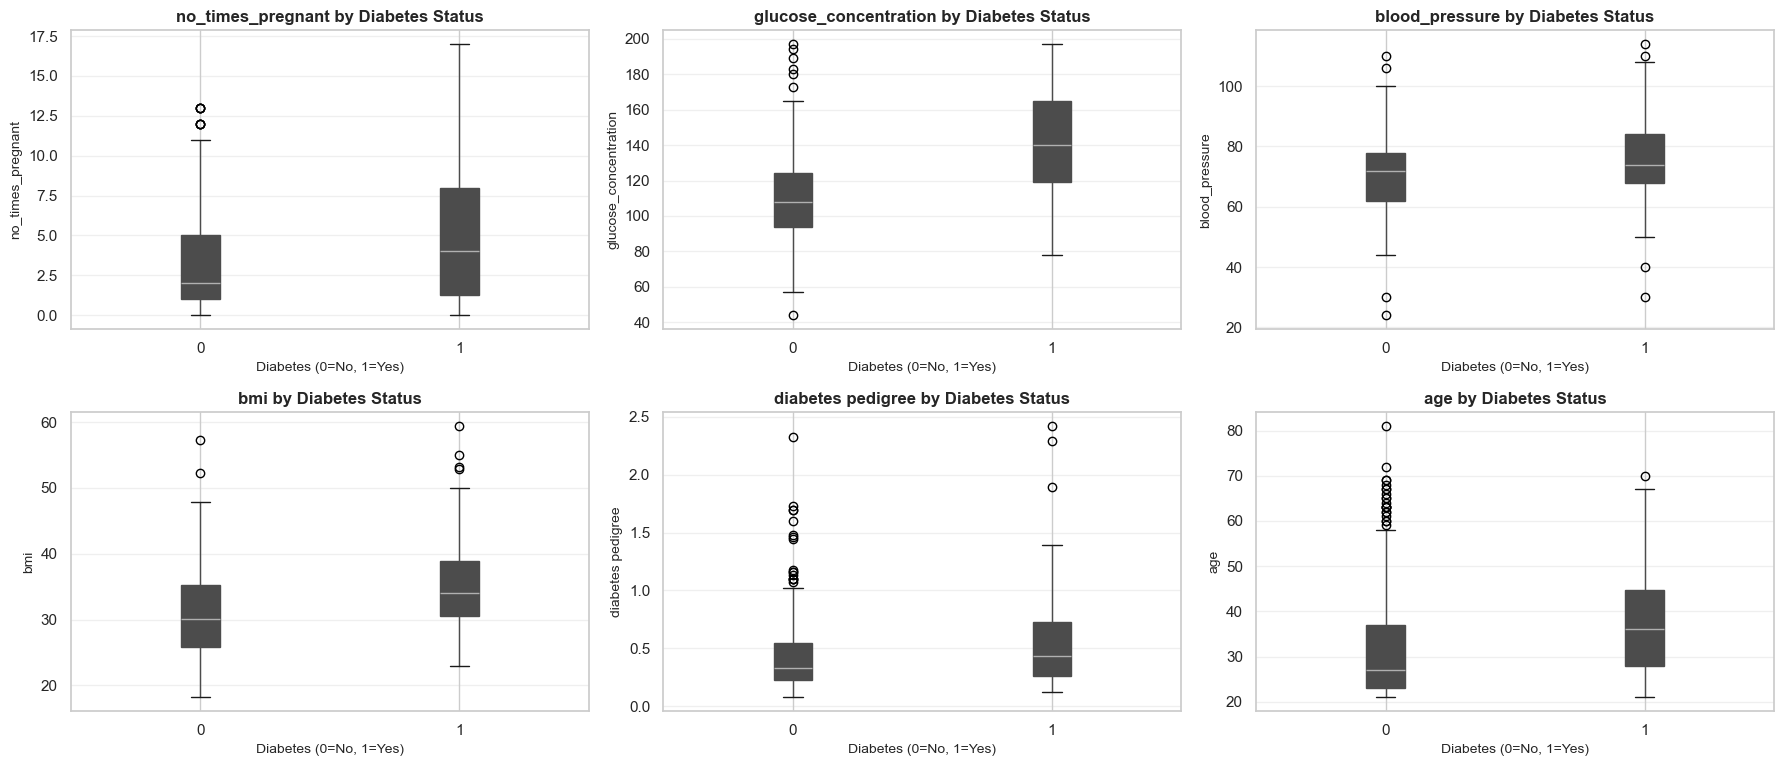

In [19]:
print_section('BOX PLOTS BY DIABETES STATUS')

### BUILD BOX PLOTS FOR ALL FEATURES BY DIABETES STATUS
n_cols = 3
n_rows = int(np.ceil(len(feature_cols_clean) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*4))
axes = axes.ravel()

for idx, col in enumerate(feature_cols_clean):
    train_clean.boxplot(column=col, by='diabetes', ax=axes[idx],
                        patch_artist=True, return_type='dict')
    axes[idx].set_title(f'{col} by Diabetes Status', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Diabetes (0=No, 1=Yes)', fontsize=10)
    axes[idx].set_ylabel(col, fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)

### HIDE UNUSED SUBPLOT
for idx in range(len(feature_cols_clean), len(axes)):
    axes[idx].axis('off')

plt.suptitle('')  # Remove default parent title
plt.tight_layout()
plt.show()

1. **Glucose concentration** shows the strongest separation between diabetic and non-diabetic groups.
    - Diabetic individuals have much higher glucose (higher median, higher quartiles, more extreme values).
    - This aligns with medical expectations and indicates glucose is the most discriminative feature.
2. Several features shift upward for diabetics (**age**, **BMI**, **pregnancies**).
    - **Age:** Diabetic individuals tend to be older on average.
    - **BMI:** Higher BMI among diabetics suggests a connection with obesity-related risk.
    - **Number of pregnancies:** The diabetic group shows higher median values.
    - These features show moderate separation but not as strong as **glucose concentration**.
3. High overlap in **blood pressure**, **skinfold thickness**, **insulin**, and **pedigree**.
    - Although the distributions overlap, diabetics tend to have:
        - Slightly higher blood pressure
        - Slightly higher skinfold thickness
        - Broader and higher insulin levels
        - Higher diabetes pedigree function (genetic risk indicator)
    - These features contribute information but *individually* are not determining factors to separate between statuses.

## SCATTER PLOTS

SCATTER PLOTS


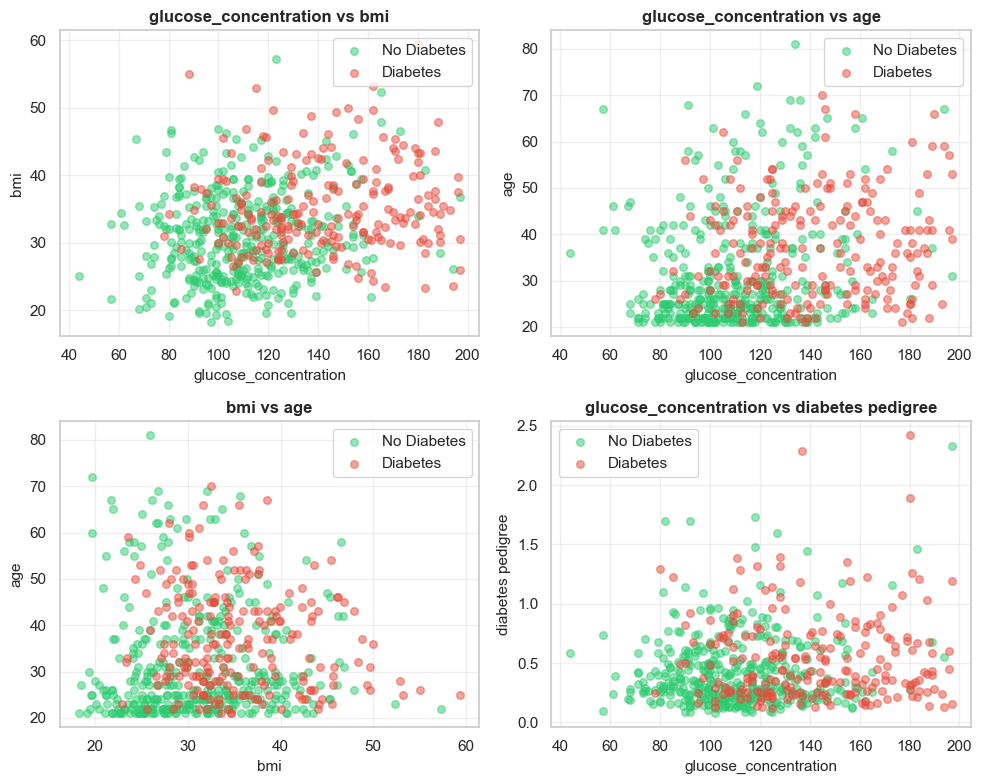

In [20]:
print_section('SCATTER PLOTS')

### CHOOSE MOST IMPORTANT FEATURES ONLY
# glucose_concentration, bmi, age, diabetes pedigree

### DEFINE THE SUBPLOT SHAPE
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

### DEFINE THE SCATTER PLOT COMBINATIONS
combinations = [
    ('glucose_concentration', 'bmi'),
    ('glucose_concentration', 'age'),
    ('bmi', 'age'),
    ('glucose_concentration', 'diabetes pedigree')
]
for idx, (feat1, feat2) in enumerate(combinations):
    ### PLOT NON-DIABETIC
    axes[idx].scatter(
        train_clean[train_clean['diabetes']==0][feat1],
        train_clean[train_clean['diabetes']==0][feat2],
        alpha=0.5, c='#2ecc71', label='No Diabetes', s=30
    )
    ### PLOT DIABETIC
    axes[idx].scatter(
        train_clean[train_clean['diabetes']==1][feat1],
        train_clean[train_clean['diabetes']==1][feat2],
        alpha=0.5, c='#e74c3c', label='Diabetes', s=30
    )
    ### SET PLOT ANNOTATIONS
    axes[idx].set_xlabel(feat1, fontsize=11)
    axes[idx].set_ylabel(feat2, fontsize=11)
    axes[idx].set_title(f'{feat1} vs {feat2}', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

1. **Glucose concentration is strongly associated with diabetes**
    - Across all plots involving glucose concentration (vs BMI, age, and diabetes pedigree), individuals with diabetes generally have higher glucose levels compared to those without diabetes.
    - This indicates that glucose concentration is a strong indicator of diabetes risk.
2. **BMI and age show moderate separation**
    - In the BMI vs age plot, individuals with diabetes tend to cluster at slightly higher BMI and older ages *compared to* those without diabetes, but there is considerable overlap.
    - This suggests BMI and age contribute to diabetes risk but are **not as definitive alone**.
3. **Diabetes pedigree contributes to risk prediction**
    - In the glucose concentration vs diabetes pedigree plot, individuals with diabetes often have higher diabetes pedigree values, especially when combined with higher glucose levels.
    - This shows that a family history of diabetes (captured by the diabetes pedigree) is an important factor when assessing diabetes risk.

Overall, glucose concentration appears to be the strongest single indicator, while BMI, age, and diabetes pedigree provide additional context that can improve risk assessment.

# 5. FEATURE ENGINEERING

In [21]:
### PRESERVE DATASETS BEFORE FEATURE ENGINEERING
train_before_FE = train_clean.copy()
test_before_FE = test_clean.copy()

## CREATE CATEGORICAL FEATURES

### BMI CATEGORIES

In [22]:
print('--- CREATE BMI CATEGORIES BASED ON WHO CLASSIFICATIONS ---')
### DEFINE THE CATEGORICAL BINS AND LABELS BASED ON WHO CLASSIFICATIONS
bins_bmi = [0, 18.5, 25, 30, 100]
labels_bmi = [0, 1, 2, 3]  # 0=Underweight, 1=Normal, 2=Overweight, 3=Obese

### DO BINNING
train_clean['bmi_category'] = pd.cut(train_clean['bmi'], bins=bins_bmi, labels=labels_bmi)
test_clean['bmi_category'] = pd.cut(test_clean['bmi'], bins=bins_bmi, labels=labels_bmi)

print('BMI CATEGORIES CREATED:')
print('0 = Underweight (<18.5)')
print('1 = Normal (18.5-25)')
print('2 = Overweight (25-30)')
print('3 = Obese (>30)')

### SHOW THE CATEGORIES FOR TRAIN DATA
print(f'\nDISTRIBUTION IN TRAIN DATA:')
print(train_clean['bmi_category'].value_counts().sort_index())

--- CREATE BMI CATEGORIES BASED ON WHO CLASSIFICATIONS ---
BMI CATEGORIES CREATED:
0 = Underweight (<18.5)
1 = Normal (18.5-25)
2 = Overweight (25-30)
3 = Obese (>30)

DISTRIBUTION IN TRAIN DATA:
bmi_category
0      2
1     84
2    155
3    373
Name: count, dtype: int64


### AGE GROUPS

In [23]:
print('--- CREATE AGE GROUPS ---')
### DEFINE DESIRED CATEGORICAL BINS & LABELS
bins_age = [20, 30, 40, 50, 100]
labels_age = [0, 1, 2, 3]  # 0=20-29, 1=30-39, 2=40-49, 3=50+

### DO BINNING FOR TEST & TRAIN DATA
train_clean['age_group'] = pd.cut(train_clean['age'], bins=bins_age, labels=labels_age)
test_clean['age_group'] = pd.cut(test_clean['age'], bins=bins_age, labels=labels_age)

print('Age Groups created:')
print('0 = 20-29 years')
print('1 = 30-39 years')
print('2 = 40-49 years')
print('3 = 50+ years')

### SHOW THE CATEGORIES FOR TRAIN DATA
print(f'\nDISTRIBUTION IN TRAIN DATA:')
print(train_clean['age_group'].value_counts().sort_index())

--- CREATE AGE GROUPS ---
Age Groups created:
0 = 20-29 years
1 = 30-39 years
2 = 40-49 years
3 = 50+ years

DISTRIBUTION IN TRAIN DATA:
age_group
0    336
1    120
2     93
3     65
Name: count, dtype: int64


### GLUCOSE RISK CATEGORIES

In [24]:
print('--- CREATE GLUCOSE RISK CATEGORIES ---')
### DEFINE DESIRED CATEGORICAL BINS & LABELS
bins_glucose = [0, 100, 126, 200]
labels_glucose = [0, 1, 2]  # 0=Normal, 1=Prediabetic, 2=Diabetic range

### DO BINNING FOR TEST & TRAIN DATA
train_clean['glucose_category'] = pd.cut(train_clean['glucose_concentration'], 
                                     bins=bins_glucose, labels=labels_glucose)
test_clean['glucose_category'] = pd.cut(test_clean['glucose_concentration'], 
                                    bins=bins_glucose, labels=labels_glucose)

print('GLUCOSE RISK CATEGORIES CREATED:')
print('0 = Normal (<100 mg/dL)')
print('1 = Prediabetic (100-126 mg/dL)')
print('2 = Diabetic range (>126 mg/dL)')

### SHOW THE CATEGORIES FOR TRAIN DATA
print(f'\nDISTRIBUTION IN TRAIN DATA:')
print(train_clean['glucose_category'].value_counts().sort_index())

--- CREATE GLUCOSE RISK CATEGORIES ---
GLUCOSE RISK CATEGORIES CREATED:
0 = Normal (<100 mg/dL)
1 = Prediabetic (100-126 mg/dL)
2 = Diabetic range (>126 mg/dL)

DISTRIBUTION IN TRAIN DATA:
glucose_category
0    163
1    225
2    226
Name: count, dtype: int64


### CONVERT CATEGORICAL FEATURES TO NUMERIC

In [25]:
train_clean['bmi_category'] = train_clean['bmi_category'].astype(int)
test_clean['bmi_category'] = test_clean['bmi_category'].astype(int)
train_clean['age_group'] = train_clean['age_group'].astype(int)
test_clean['age_group'] = test_clean['age_group'].astype(int)
train_clean['glucose_category'] = train_clean['glucose_category'].astype(int)
test_clean['glucose_category'] = test_clean['glucose_category'].astype(int)

print('\n✅ CATEGORICAL FEATURES CREATED!')


✅ CATEGORICAL FEATURES CREATED!


## CREATE RATIO & INTERACTION FEATURES

### GLUCOSE-BMI RATIO

In [26]:
### CREATE
train_clean['glucose_bmi_ratio'] = train_clean['glucose_concentration']/ (train_clean['bmi'] + 1e-6)
test_clean['glucose_bmi_ratio'] = test_clean['glucose_concentration']/ (test_clean['bmi'] + 1e-6)

### SHOW MEAN & RANGE FOR TRAIN DATA
print('--- CREATE GLUCOSE-BMI RATIO ---')
print(f"Mean: {train_clean['glucose_bmi_ratio'].mean():.2f}")
print(f"Range: {train_clean['glucose_bmi_ratio'].min():.2f} to {train_clean['glucose_bmi_ratio'].max():.2f}")

--- CREATE GLUCOSE-BMI RATIO ---
Mean: 3.86
Range: 1.48 to 8.26


### BMI-AGE INTERACTION

In [27]:
### CREATE
train_clean['bmi_age_interaction'] = train_clean['bmi'] * train_clean['age']
test_clean['bmi_age_interaction'] = test_clean['bmi'] * test_clean['age']

### SHOW MEAN FOR TRAIN DATA
print('--- CREATE BMI-AGE INTERACTION ---')
print(f"Mean: {train_clean['bmi_age_interaction'].mean():.2f}")

--- CREATE BMI-AGE INTERACTION ---
Mean: 1082.14


### PREGNANCY-AGE INTERACTION

In [28]:
### CREATE
train_clean['pregnancy_age_interaction'] = train_clean['no_times_pregnant'] * train_clean['age']
test_clean['pregnancy_age_interaction'] = test_clean['no_times_pregnant'] * test_clean['age']

### SHOW MEAN FOR TRAIN DATA
print('--- CREATE PREGNANCY-AGE INTERACTION ---')
print(f"Mean: {train_clean['pregnancy_age_interaction'].mean():.2f}")

print('\n✅ Ratio and interaction features created successfully!')

--- CREATE PREGNANCY-AGE INTERACTION ---
Mean: 149.79

✅ Ratio and interaction features created successfully!


## CREATE HIGH-RISK FLAGS

### HIGH GLUCOSE FLAG

In [29]:
### DEFINE THRESHOLD
glucose_threshold = 130  # mg/dL (diabetic range)

### CREATE FLAGS
train_clean['high_glucose_flag'] = (train_clean['glucose_concentration'] >= glucose_threshold).astype(int)
test_clean['high_glucose_flag'] = (test_clean['glucose_concentration'] >= glucose_threshold).astype(int)

### SHOW FLAG LOGIC & COUNT FOR TRAIN DATA 
print('--- CREATE HGH GLUCOSE FLAG ---')
print(f'high_glucose_flag = 1 if glucose_concentration >= {glucose_threshold} mg/dL; 0 otherwise')
print(f'{train_clean["high_glucose_flag"].sum()} patients ({train_clean["high_glucose_flag"].mean()*100:.1f}%) flagged in TRAIN data')

--- CREATE HGH GLUCOSE FLAG ---
high_glucose_flag = 1 if glucose_concentration >= 130 mg/dL; 0 otherwise
206 patients (33.6%) flagged in TRAIN data


### HIGH BMI FLAG

In [30]:
### DEFINE THRESHOLD
bmi_threshold = 30  # Obese category

### CREATE FLAGS
train_clean['high_bmi_flag'] = (train_clean['bmi'] >= bmi_threshold).astype(int)
test_clean['high_bmi_flag'] = (test_clean['bmi'] >= bmi_threshold).astype(int)

### SHOW FLAG LOGIC & COUNT FOR TRAIN DATA
print('--- CREATE HIGH BMI FLAG ---')
print(f'high_bmi_flag = 1 if BMI >= {bmi_threshold}; 0 otherwise')
print(f'{train_clean["high_bmi_flag"].sum()} patients ({train_clean["high_bmi_flag"].mean()*100:.1f}%) flagged in TRAIN data') 

--- CREATE HIGH BMI FLAG ---
high_bmi_flag = 1 if BMI >= 30; 0 otherwise
379 patients (61.7%) flagged in TRAIN data


### HIGH BLOOD PRESSURE FLAG

In [31]:
### DEFINE THRESHOLD
bp_threshold = 90  # mmHg (hypertension stage 1)

### CREATE FLAGS
train_clean['high_bp_flag'] = (train_clean['blood_pressure'] >= bp_threshold).astype(int)
test_clean['high_bp_flag'] = (test_clean['blood_pressure'] >= bp_threshold).astype(int)

### SHOW FLAG LOGIC & COUNT FOR TRAIN DATA
print('--- CREATE HIGH BLOOD PRESSURE FLAG ---')
print(f'high_bp_flag = 1 if BP >= {bp_threshold} mmHg; 0 otherwise')
print(f'{train_clean["high_bp_flag"].sum()} patients ({train_clean["high_bp_flag"].mean()*100:.1f}%) flagged in TRAIN data') 

--- CREATE HIGH BLOOD PRESSURE FLAG ---
high_bp_flag = 1 if BP >= 90 mmHg; 0 otherwise
49 patients (8.0%) flagged in TRAIN data


### HIGH AGE FLAG

In [32]:
### DEFINE THRESHOLD
age_threshold = 40

### CREATE FLAGS
train_clean['high_age_flag'] = (train_clean['age'] >= age_threshold).astype(int)
test_clean['high_age_flag'] = (test_clean['age'] >= age_threshold).astype(int)

### SHOW FLAG LOGIC & COUNT FOR TRAIN DATA
print('--- CREATE HIGH AGE FLAG ---')
print(f'high_age_flag = 1 if age >= {age_threshold}; 0 otherwise')
print(f'{train_clean["high_age_flag"].sum()} patients ({train_clean["high_age_flag"].mean()*100:.1f}%) flagged in TRAIN data')

--- CREATE HIGH AGE FLAG ---
high_age_flag = 1 if age >= 40; 0 otherwise
167 patients (27.2%) flagged in TRAIN data


### HIGH PREGNANCY COUNT FLAG

In [33]:
### DEFINE THRESHOLD
preg_threshold = 5

### CREATE FLAGS
train_clean['high_preg_flag'] = (train_clean['no_times_pregnant'] >= preg_threshold).astype(int)
test_clean['high_preg_flag'] = (test_clean['no_times_pregnant'] >= preg_threshold).astype(int)

### SHOW FLAG LOGIC & COUNT FOR TRAIN DATA
print('--- CREATE HIGH PREGNANCY COUNT FLAG ---')
print(f'high_preg_flag = 1 if pregnancies >= {preg_threshold}; 0 otherwise')
print(f'{train_clean["high_preg_flag"].sum()} patients ({train_clean["high_preg_flag"].mean()*100:.1f}%) flagged in TRAIN data')

--- CREATE HIGH PREGNANCY COUNT FLAG ---
high_preg_flag = 1 if pregnancies >= 5; 0 otherwise
216 patients (35.2%) flagged in TRAIN data


### COMBINED RISK SCORE

In [34]:
### SUM THE HIGH-RISK FLAGS INTO RISK SCORES COLUMNS
train_clean['risk_score'] = (train_clean['high_glucose_flag'] + 
                             train_clean['high_bmi_flag'] + 
                             train_clean['high_bp_flag'] + 
                             train_clean['high_age_flag'] + 
                             train_clean['high_preg_flag'])
test_clean['risk_score'] = (test_clean['high_glucose_flag'] + 
                            test_clean['high_bmi_flag'] + 
                            test_clean['high_bp_flag'] + 
                            test_clean['high_age_flag'] + 
                            test_clean['high_preg_flag'])

### SHOW COMBINED RISK SCORE FOR TRAIN DATA
print('--- CREATE COMBINED RISK SCORE ---')
print('risk_score: Sum of all high-risk flags (0-5)')
print(f'Mean risk score: {train_clean["risk_score"].mean():.2f}')

print(f'\nDISTRIBUTION IN TRAIN DATA:')
print(train_clean['risk_score'].value_counts().sort_index())

print('\n✅ High-risk flags created successfully!')

--- CREATE COMBINED RISK SCORE ---
risk_score: Sum of all high-risk flags (0-5)
Mean risk score: 1.66

DISTRIBUTION IN TRAIN DATA:
risk_score
0    113
1    200
2    149
3     99
4     43
5     10
Name: count, dtype: int64

✅ High-risk flags created successfully!


## CREATE POLYNOMIAL FEATURES

In [35]:
print('--- CREATE SQUARED FEATURES FOR NON-LINEAR RELATIONSHIPS ---')

### GLUCOSE SQUARED
train_clean['glucose_squared'] = train_clean['glucose_concentration'] ** 2
test_clean['glucose_squared'] = test_clean['glucose_concentration'] ** 2
print('glucose_squared: Glucose concentration squared')

### BMI SQUARED
train_clean['bmi_squared'] = train_clean['bmi'] ** 2
test_clean['bmi_squared'] = test_clean['bmi'] ** 2
print('bmi_squared: BMI squared')

### AGE SQUARED
train_clean['age_squared'] = train_clean['age'] ** 2
test_clean['age_squared'] = test_clean['age'] ** 2
print('age_squared: Age squared')

print('\n✅ Polynomial features created successfully!')

--- CREATE SQUARED FEATURES FOR NON-LINEAR RELATIONSHIPS ---
glucose_squared: Glucose concentration squared
bmi_squared: BMI squared
age_squared: Age squared

✅ Polynomial features created successfully!


## CREATE LOG-TRANSFORMED FEATURES

In [36]:
print('--- CREATE LOG-TRANSFORMED FEATURES FOR SKEWED FEATURES ---')

### DIABETES PEDIGREE
train_clean['pedigree_log'] = np.log1p(train_clean['diabetes pedigree'])
test_clean['pedigree_log'] = np.log1p(test_clean['diabetes pedigree'])
print('pedigree_log: Log-transformed diabetes pedigree function')

print('\n✅ Log-transformed features created successfully!')

--- CREATE LOG-TRANSFORMED FEATURES FOR SKEWED FEATURES ---
pedigree_log: Log-transformed diabetes pedigree function

✅ Log-transformed features created successfully!


## FEATURE ENGINEERING SUMMARY

In [37]:
print_section('FEATURE ENGINEERING SUMMARY')

### FEATURE BEFORE AND AFTER FEATURE ENGINEERING
original_features = list(train_before_FE.columns)
new_features = [col for col in train_clean.columns if col not in original_features]

print(f'\n--- FEATURE COUNTS ---')
print(f'\nOriginal feature count: {len(original_features)}')
print(f'New features created: {len(new_features)}')
print(f'Total feature count: {len(train_clean.columns)}')

### NEW FEATURES
print(f'\n--- NEW FEATURES CREATED ---')
for i, feat in enumerate(new_features, 1):
    print(f'{i:2d}. {feat}')

### DISPLAY SAMPLE VALUES OF ENGINEERED FEATURES
print(f'\n--- SAMPLE VALUES OF ENGINEERED FEATURES ---')
display(train_clean[new_features].head())

print('\n✅ FEATURE ENGINEERING COMPLETED!')
print('Ready to proceed with model training.\n')

FEATURE ENGINEERING SUMMARY

--- FEATURE COUNTS ---

Original feature count: 8
New features created: 16
Total feature count: 24

--- NEW FEATURES CREATED ---
 1. bmi_category
 2. age_group
 3. glucose_category
 4. glucose_bmi_ratio
 5. bmi_age_interaction
 6. pregnancy_age_interaction
 7. high_glucose_flag
 8. high_bmi_flag
 9. high_bp_flag
10. high_age_flag
11. high_preg_flag
12. risk_score
13. glucose_squared
14. bmi_squared
15. age_squared
16. pedigree_log

--- SAMPLE VALUES OF ENGINEERED FEATURES ---


,bmi_category,age_group,glucose_category,glucose_bmi_ratio,bmi_age_interaction,pregnancy_age_interaction,high_glucose_flag,high_bmi_flag,high_bp_flag,high_age_flag,high_preg_flag,risk_score,glucose_squared,bmi_squared,age_squared,pedigree_log
0,3,0,1,3.284457,886.6,52,0,1,0,0,0,1,12544,1162.81,676,0.273837
1,3,3,2,3.907104,1866.6,561,1,1,1,1,1,5,20449,1339.56,2601,0.226338
2,3,0,0,2.447368,874.0,46,0,1,0,0,0,1,8649,1444.00,529,0.515216
3,3,2,1,3.084833,1594.9,41,0,1,0,1,0,2,14400,1513.21,1681,0.771034
4,3,0,2,3.950617,874.8,81,0,1,0,0,0,1,16384,1049.76,729,0.437610



✅ FEATURE ENGINEERING COMPLETED!
Ready to proceed with model training.



In [38]:
### DISPLAY FINAL DATASETS READY FOR ML
print('--- FINAL DATASETS READY FOR ML ---')
print(f'Train shape: {train_clean.shape}')
print(f'Test shape: {test_clean.shape}')
print(f'\nFirst 5 rows of TRAIN data:')
display(train_clean.head())

--- FINAL DATASETS READY FOR ML ---
Train shape: (614, 24)
Test shape: (154, 23)

First 5 rows of TRAIN data:


,p_id,no_times_pregnant,glucose_concentration,blood_pressure,bmi,diabetes pedigree,age,diabetes,bmi_category,age_group,glucose_category,glucose_bmi_ratio,bmi_age_interaction,pregnancy_age_interaction,high_glucose_flag,high_bmi_flag,high_bp_flag,high_age_flag,high_preg_flag,risk_score,glucose_squared,bmi_squared,age_squared,pedigree_log
0,316,2,112,68,34.1,0.315,26,0,3,0,1,3.284457,886.6,52,0,1,0,0,0,1,12544,1162.81,676,0.273837
1,25,11,143,94,36.6,0.254,51,1,3,3,2,3.907104,1866.6,561,1,1,1,1,1,5,20449,1339.56,2601,0.226338
2,710,2,93,64,38.0,0.674,23,1,3,0,0,2.447368,874.0,46,0,1,0,0,0,1,8649,1444.00,529,0.515216
3,658,1,120,80,38.9,1.162,41,0,3,2,1,3.084833,1594.9,41,0,1,0,1,0,2,14400,1513.21,1681,0.771034
4,542,3,128,72,32.4,0.549,27,1,3,0,2,3.950617,874.8,81,0,1,0,0,0,1,16384,1049.76,729,0.437610


# 6. MACHINE LEARNING
- Goal: Train classification models and select the best one.
- Algorithms: k-Nearest Neighbors, Decision Tree, Random Forest.

In [39]:
### MAKE COPIES TO PRESERVE DATA
train_before_ML = train_clean.copy()
test_before_ML = test_clean.copy()

## PREP DATA FOR MODELING

In [40]:
print('--- PREP DATA FOR MODELING ---')

### DROP NON-PREDICTIVE IDENTIFIER (p_id) AND SEPARATE FEATURES (X) FROM TARGET (y)
X = train_clean.drop(['p_id', 'diabetes'], axis=1)
y = train_clean['diabetes']
X_test_final = test_clean.drop(['p_id'], axis=1) # Reserve for final predictions

### SPLIT TRAIN DATA INTO 80% TRAINING & 20% VALIDATION
# Set the random_state seed (42) to ensure same random split for every run
# stratify=y to have equal proportion of each class in train & val during split, based on y
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'\nTrain set: {X_train.shape}')
print(f'Validation set: {X_val.shape}')

### FEATURE SCALING
scaler = StandardScaler()
# FIT THE SCALER ON TRAIN SETS ONLY AND TRANSFORM IT
X_train_scaled = scaler.fit_transform(X_train)
# TRANSFORM THE VALIDATION AND TEST SETS USING THE SAME SCALER
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)

print('\n✅ Data prepared for modeling')

--- PREP DATA FOR MODELING ---

Train set: (491, 22)
Validation set: (123, 22)

✅ Data prepared for modeling


## TRAIN CLASSIFICATION MODELS

In [41]:
### INITIALIZE MODELS IN A DICTIONARY
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

### DEFINE AN EMPTY LIST TO STORE THE TRAINING RESULTS
results = [] 

### LOOP THROUGH EACH MODEL
for name, model in models.items():
    ### SHOW WHAT MODEL IS BEING TRAINED
    print(f'\nTraining {name}...')
    
    ### TRAIN MODEL
    model.fit(X_train_scaled, y_train)
    
    ### USE TRAINED MODEL TO PREDICT THE TARGET (y) IN THE VALIDATION SET
    y_pred = model.predict(X_val_scaled)
    
    ### CALCULATE METRICS
    accuracy = accuracy_score(y_val, y_pred) # % of correct predictions overall
    precision = precision_score(y_val, y_pred) # % of predicted positives that are actually positive
    recall = recall_score(y_val, y_pred) # % of actual positives correctly predicted
    f1 = f1_score(y_val, y_pred) # Harmonic mean of precision & recall (balances both)
    
    ### STORE RESULTS
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

    ### SHOW REPORT
    print(f'☑️ {name} trained')
    print(f'- Accuracy: {accuracy:.3f}')
    print(f'- Precision: {precision:.3f}')
    print(f'- Recall: {recall:.3f}')
    print(f'- F1-Score: {f1:.3f}')

print('\n✅ All models trained successfully')


Training k-Nearest Neighbors...
☑️ k-Nearest Neighbors trained
- Accuracy: 0.805
- Precision: 0.732
- Recall: 0.698
- F1-Score: 0.714

Training Decision Tree...
☑️ Decision Tree trained
- Accuracy: 0.764
- Precision: 0.646
- Recall: 0.721
- F1-Score: 0.681

Training Random Forest...
☑️ Random Forest trained
- Accuracy: 0.829
- Precision: 0.739
- Recall: 0.791
- F1-Score: 0.764

✅ All models trained successfully


## COMPARE MODEL PERFORMANCE

--- MODEL PERFORMANCE METRICS COMPARISON ---


,Model,Accuracy,Precision,Recall,F1-Score
2,Random Forest,0.829268,0.739130,0.790698,0.764045
0,k-Nearest Neighbors,0.804878,0.731707,0.697674,0.714286
1,Decision Tree,0.764228,0.645833,0.720930,0.681319


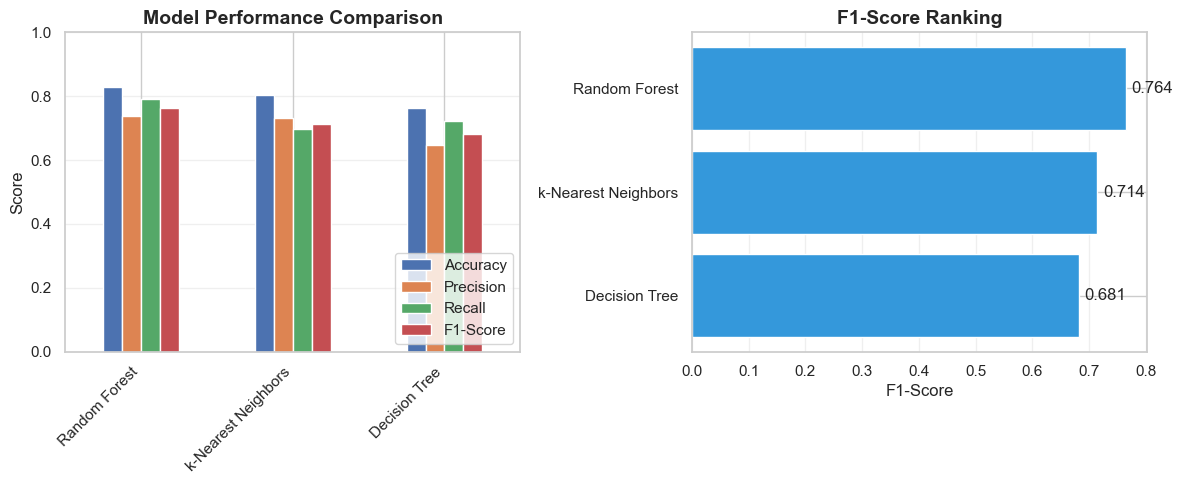


🏆 BEST MODEL: Random Forest
   F1-Score: 0.764


In [42]:
### CREATE COMPARISON DF FROM RESULTS, SORTED BY DESCENDING F1-Score
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print('--- MODEL PERFORMANCE METRICS COMPARISON ---')
display(results_df)

### VISUALIZE COMPARISON IN BAR CHART
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

### LEFT SUBPLOT axes[0] TO COMPARE ALL MODEL PERFORMANCE METRICS
# Plot on the left
ax1 = axes[0]
results_df.plot(x='Model', y=['Accuracy', 'Precision', 'Recall', 'F1-Score'], 
                kind='bar', ax=ax1)

# Set plot annotations
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12)
ax1.set_xlabel('')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

### RIGHT SUBPLOT axes[1] TO COMPARE F1-Score ONLY
# Plot on the right
ax2 = axes[1]
results_df_sorted = results_df.sort_values('F1-Score')

# Set plot annotations
ax2.barh(results_df_sorted['Model'], results_df_sorted['F1-Score'], color='#3498db')
ax2.set_title('F1-Score Ranking', fontsize=14, fontweight='bold')
ax2.set_xlabel('F1-Score', fontsize=12)
ax2.grid(axis='x', alpha=0.3)

# Add F1-Score value labels
for i, v in enumerate(results_df_sorted['F1-Score']):
    ax2.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_f1 = results_df.iloc[0]['F1-Score']

print(f'\n🏆 BEST MODEL: {best_model_name}')
print(f'   F1-Score: {best_f1:.3f}')

## EVALUATE BEST MODEL

--- CONFUSION MATRIX: Random Forest ---


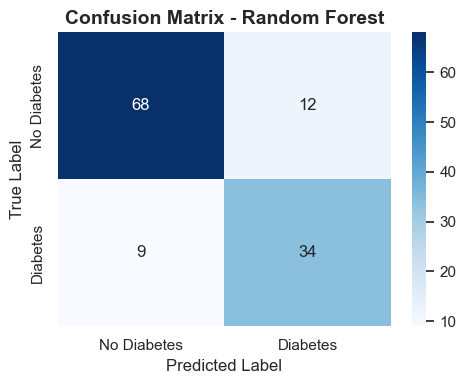


--- Classification Report: Random Forest ---
              precision    recall  f1-score   support

 No Diabetes       0.88      0.85      0.87        80
    Diabetes       0.74      0.79      0.76        43

    accuracy                           0.83       123
   macro avg       0.81      0.82      0.82       123
weighted avg       0.83      0.83      0.83       123



In [43]:
### GET BEST MODEL AND ITS PREDICTIONS ON y IN THE VALIDATION SET
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_val_scaled)

### CONFUSION MATRIX TO SEE WHERE THE MODEL IS MAKING MISTAKES
print(f'--- CONFUSION MATRIX: {best_model_name} ---')
cm = confusion_matrix(y_val, y_pred_best)

### VISUALIZE CONFUSION MATRIX
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', # annot=True adds the values; fmt='d' present them as int
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])

# Set plot annotations
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

### CLASSIFICATION REPORT
# Precision: Of all patients predicted as diabetics, how many actually are?
# Recall: Of all actual diabetics, how many were correctly identified?
# F1-Score: Balances precision and recall - important when false negatives are costly.
# Support: Number of true samples for each class, gives context to the metrics
print(f'\n--- Classification Report: {best_model_name} ---')
print(classification_report(y_val, y_pred_best, target_names=['No Diabetes', 'Diabetes']))

**CONFUSION MATRIX**
- ✅ Most non-diabetic patients are correctly identified (67/80).
- ⚠️ Some diabetic patients are missed (10/43).

**CLASSIFICATION REPORT**
- Accuracy: 0.81 => 81% of predictions are correct overall.
- Macro avg (unweighted): 0.80 => average of F1 across classes (diabetics & non-diabetics), treats both classes equally.
- Weighted avg: 0.81 => average of F1 weighted by class size, slightly favors the majority class (non-diabetics).
- F1-Score for diabetic patients (0.74) is lower than for non-diabetic (0.85) => the model struggles more with detecting diabetics.

## MAKE PREDICTIONS ON TEST DATASET USING BEST MODEL 

In [44]:
### MAKE PREDICTIONS ON TEST DATASET USING BEST MODEL
test_predictions = best_model.predict(X_test_scaled)

### CREATE A DF OF PREDICTION RESULTS
predictions_df = pd.DataFrame({
    'p_id': test_clean['p_id'],
    'predicted_diabetes': test_predictions
})

print(f'\n✅ Predictions completed for {len(predictions_df)} test samples')
print(f'Prediction distribution:')
print(predictions_df['predicted_diabetes'].value_counts())

### SHOW SAMPLE PREDICTIONS
print(f'\nSample predictions:')
display(predictions_df.head())


✅ Predictions completed for 154 test samples
Prediction distribution:
predicted_diabetes
0    96
1    58
Name: count, dtype: int64

Sample predictions:


,p_id,predicted_diabetes
0,437,1
1,411,0
2,639,0
3,213,1
4,181,0


## ML SUMMARY

In [45]:
print(f'''
--- ML RESULTS SUMMARY ---
- ALGORITHMS TESTED: {', '.join(models)}
- BEST MODEL: {best_model_name}                        
- PERFORMANCE (VALIDATION SET):      
    - Accuracy:  {results_df.iloc[0]["Accuracy"]:.4f}     
    - Precision: {results_df.iloc[0]["Precision"]:.4f}     
    - Recall:    {results_df.iloc[0]["Recall"]:.4f}      
    - F1-Score:  {results_df.iloc[0]["F1-Score"]:.4f}
- TEST PREDICTIONS:                  
   - Total samples: {len(predictions_df)}
   - Predictions saved in: predictions_df 
''')

print('\n✅ ML COMPLETED!')
print('✅ PROJECT COMPLETED!')


--- ML RESULTS SUMMARY ---
- ALGORITHMS TESTED: k-Nearest Neighbors, Decision Tree, Random Forest
- BEST MODEL: Random Forest                        
- PERFORMANCE (VALIDATION SET):      
    - Accuracy:  0.8293     
    - Precision: 0.7391     
    - Recall:    0.7907      
    - F1-Score:  0.7640
- TEST PREDICTIONS:                  
   - Total samples: 154
   - Predictions saved in: predictions_df 


✅ ML COMPLETED!
✅ PROJECT COMPLETED!
